# Análise do Titanic - Parte 3

## Importando as bases de dados de treino e teste

In [90]:
import pandas as pd

* Vamos utilizar a mesma base que finalizou-se a Parte 2.

In [91]:
treino = pd.read_csv('Parte 2/base_parte2.csv')

In [92]:
treino.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,MaleCheck,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,male,22.0,1,0,7.2500,S,1,0,0,1
1,2,1,1,female,38.0,1,0,71.2833,C,0,1,0,0
2,3,1,3,female,26.0,0,0,7.9250,S,0,0,0,1


In [93]:
teste = pd.read_csv('Parte 2/base_teste_parte2.csv')

In [94]:
teste.head(3)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,MaleCheck,Embarked_C,Embarked_Q,Embarked_S
0,892,3,male,34.5,0,0,7.8292,Q,1,0,1,0
1,893,3,female,47.0,1,0,7.0000,S,0,0,0,1
2,894,2,male,62.0,0,0,9.6875,Q,1,0,1,0


* Novamente, podemos aplicar as nossas bases nos modelos de Machine Learning
    - É necessário retirar as colunas do tipo *object*

In [95]:
treino = treino.drop(['Sex', 'Embarked'], axis=1)
teste = teste.drop(['Sex', 'Embarked'], axis=1)

In [96]:
from sklearn.model_selection import train_test_split

In [97]:
X = treino.drop(['PassengerId', 'Survived'], axis=1)
y = treino.Survived

In [98]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

* Árvore de Decisão

In [99]:
from sklearn import tree

In [100]:
clf_ac = tree.DecisionTreeClassifier(random_state=42)
clf_ac = clf_ac.fit(X_train, y_train)

y_pred_ac = clf_ac.predict(X_val)

* KNeighborsClassifier

In [101]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn = clf_knn.fit(X_train, y_train)

y_pred_knn = clf_knn.predict(X_val)

* Regressão Logística

In [102]:
from sklearn.linear_model import LogisticRegression

clf_rl = LogisticRegression(random_state=42, max_iter=1000)
clf_rl = clf_rl.fit(X_train, y_train)

y_pred_rl = clf_rl.predict(X_val)

* Avaliando a acurácia de cada modelo

In [103]:
from sklearn.metrics import accuracy_score

In [104]:
as_ac = accuracy_score(y_val, y_pred_ac)

as_ac

0.7491525423728813

In [105]:
as_knn = accuracy_score(y_val, y_pred_knn)

as_knn

0.7152542372881356

In [106]:
as_rl = accuracy_score(y_val, y_pred_rl)

as_rl

0.8169491525423729

* Salvando esses resultados em DataFrames

In [107]:
as_df = pd.DataFrame({
    'modelos': ['arvore', 'knn', 'reg. log.'],
    'inicial': [as_ac, as_knn, as_rl]
})

as_df

,modelos,inicial
0,arvore,0.749153
1,knn,0.715254
2,reg. log.,0.816949


#### Analisando a escala dos dados

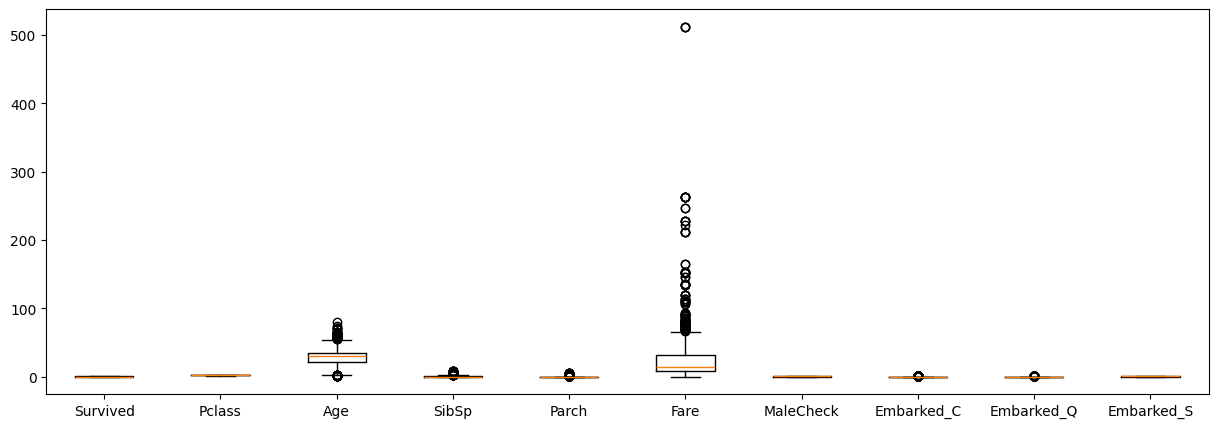

In [108]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,5))

ax.boxplot(treino.iloc[:, 1:11])
ax.set_xticks(range(1, treino.iloc[:, 1:11].shape[1]+1), treino.iloc[:, 1:11].columns)

plt.show()

* Quando analisamos as features *Age* e *Fare* em comparação com as outras features, percebe-se que ambas estão fora de escala. O que isso significa?
    - Os valores destas features estão em intervalos numéricos muito diferentes dos intervalos das outras features.
    - Por que isso é relevante?
        - Muitos algoritmos de Machine Learning (como Regressão Logística, KNN, SVM e Neural Networking) são muito sensíveis à escala dos dados:
            - Features com valores maiores dominam as métricas de distância;
            - O processo de otimização pode ficar mais difícil, onde os pesos (bias) associados às features fora de escala variam muito mais;

    - Solução: aplicar normalização ou padronização
        - Aqui vamos utilizar o **RobustScaler** -> ele trata os *outliers* destas features de maneira robusta, isto é, sem perder precisão

* StandardScaler: $$z = \frac{x - \mu}{\sigma},$$
onde $\mu$ é a média da feature e $\sigma$ é o desvio padrão. Após reescalar, os dados ficam com média 0 e desvio padrão 1. 
    - Sensível a outliers: se houver valores muito extremos, a média e o desvio padrão são distorcidos.
    - Bom para dados em perfil próximo de Gaussiano

* RobustScaler: $$z = \frac{x - med}{IQR},$$
onde $$med$$ é a mediana da feature e $IQR = Q_3 - Q_1$ é o intervalor interquartílico, ou seja, a diferença entre o 3º e o 1º quartil. Após reescalar, os dados ficam centrados na mediana e escalados pelo $IQR$
    - Mais robustos a outliers, porque a mediana e $IQR$ não são tão influenciados por valores extremos
    - Bom para dados com perfil assimétrico

In [109]:
from sklearn.preprocessing import RobustScaler

In [110]:
transformer = RobustScaler().fit(treino[['Age', 'Fare']])

In [111]:
transformer.transform(treino[['Age', 'Fare']])

array([[-0.59223982, -0.3120106 ],
       [ 0.63852941,  2.46124229],
       [-0.28454751, -0.28277666],
       ...,
       [ 0.        ,  0.38960398],
       [-0.28454751,  0.67328148],
       [ 0.17699095, -0.29035583]])

In [112]:
treino[['Age', 'Fare']] = transformer.transform(treino[['Age', 'Fare']])

In [113]:
# Base de teste
transformer_teste = RobustScaler().fit(teste[['Age', 'Fare']])
transformer_teste.transform(teste[['Age', 'Fare']])

array([[ 3.31561540e-01, -2.80670389e-01],
       [ 1.31195370e+00, -3.15799731e-01],
       [ 2.48842429e+00, -2.01942875e-01],
       [-2.56673754e-01, -2.45367350e-01],
       [-6.48830617e-01, -9.17929860e-02],
       [-1.27628160e+00, -2.21536845e-01],
       [-2.13796362e-02, -2.89143458e-01],
       [-3.35105126e-01,  6.16237788e-01],
       [-9.62556107e-01, -3.06089594e-01],
       [-7.27261989e-01,  4.10765881e-01],
       [ 0.00000000e+00, -2.77848857e-01],
       [ 1.23352232e+00,  4.89141763e-01],
       [-5.70399244e-01,  2.87289974e+00],
       [ 2.56685566e+00,  4.89141763e-01],
       [ 1.31195370e+00,  1.97934266e+00],
       [-4.91967871e-01,  5.62044043e-01],
       [ 3.70777227e-01, -8.91451521e-02],
       [-7.27261989e-01, -3.06267529e-01],
       [-2.56673754e-01, -2.76611789e-01],
       [ 1.15509095e+00, -3.06267529e-01],
       [ 1.93940468e+00,  1.90414418e+00],
       [-1.66843846e+00, -4.78025097e-01],
       [ 0.00000000e+00,  7.29916710e-01],
       [-7.

In [114]:
teste[['Age', 'Fare']] = transformer_teste.transform(teste[['Age', 'Fare']])

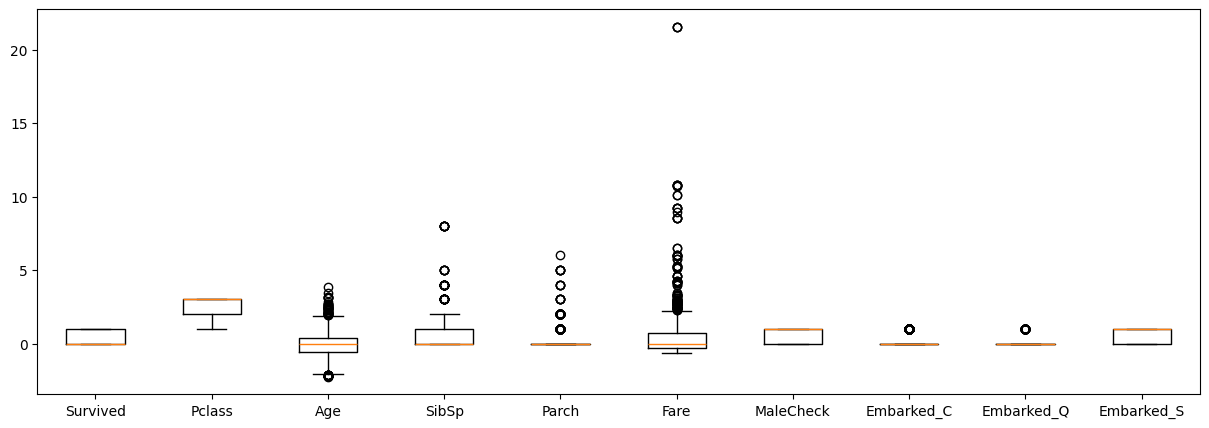

In [115]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,5))

ax.boxplot(treino.iloc[:, 1:11])
ax.set_xticks(range(1, treino.iloc[:, 1:11].shape[1]+1), treino.iloc[:, 1:11].columns)

plt.show()

In [116]:
treino.head(3)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,MaleCheck,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,-0.592240,1,0,-0.312011,1,0,0,1
1,2,1,1,0.638529,1,0,2.461242,0,1,0,0
2,3,1,3,-0.284548,0,0,-0.282777,0,0,0,1


* Realizando o treinamneto do modelo após reescalar os dados 

In [117]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

In [118]:
X = treino.drop(['PassengerId', 'Survived'], axis=1)
y = treino.Survived

In [119]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

* Árvore de Decisão

In [120]:
from sklearn import tree

clf_ac = tree.DecisionTreeClassifier(random_state=42)
clf_ac = clf_ac.fit(X_train, y_train)

y_pred_ac = clf_ac.predict(X_val)

as_ac = accuracy_score(y_val, y_pred_ac)

as_ac

0.7491525423728813

* KNeighborsClassifier

In [121]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn = clf_knn.fit(X_train, y_train)

y_pred_knn = clf_knn.predict(X_val)

as_knn = accuracy_score(y_val, y_pred_knn)

as_knn

0.8

* Regressão Logística

In [122]:
from sklearn.linear_model import LogisticRegression

clf_rl = LogisticRegression(random_state=42, max_iter=1000)
clf_rl = clf_rl.fit(X_train, y_train)

y_pred_rl = clf_rl.predict(X_val)

as_rl = accuracy_score(y_val, y_pred_rl)

as_rl

0.8169491525423729

In [123]:
X_teste = teste.drop('PassengerId', axis=1)

y_pred = clf_rl.predict(X_teste)

teste['Survived'] = y_pred

In [124]:
base_envio = teste[['PassengerId', 'Survived']]

base_envio.to_csv('titanic_previsao3.csv', index=False)

* Pontuação no Kaggle de 0.76315

In [34]:
as_df['escala'] = [as_ac, as_knn, as_rl]

as_df

,modelos,inicial,escala
0,arvore,0.749153,0.749153
1,knn,0.715254,0.800000
2,reg. log.,0.816949,0.816949


* Nota-se que, o modelo de Árvore de Decisão não se alterou, já que não depende de distância entre pontos para classificar, entretanto, apesar da Regressão Logística dependender da distância entre valores e reais e previstos, aqui não houve umudanças. Já para o caso do modelo KNN, o qual depende fortemente das distânicas, entender e reestruturar a escala da base de dados foi essencial para aumentar a acurácia do modelo.

#### Analisando outras features

* Como podemos perceber, desde a análise realizada na Parte1, não utilizamos ou entramos afundo das features SibSp e Parch
    - SibSp: número de irmãos/cônjuges a bordo do Titanic
    - Parch: número de pais/filhos a bordo do Titanic

* Podemos tentar entender como essas duas features influenciam na taxa de sobrevivência ao desastre do Titanic

In [35]:
# Verificando a sobrevivência para SibS

treino.groupby('SibSp')['Survived'].mean()

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

* Este resultado é entendido como:
    - Das pessoas que viajavam sozinhas (SibSp = 0), ~34% sobreviveram
    - Das pessoas que viajavam com *pelo menos* uma pessoa (SibSp = 1), ~53% sobreviveram
    - E se estende para os outros

* Podemos ter uma análise prévia destes valores: em um desastre como o do Titanic, a tendência é que Mulheres e Crianças sejam salvas. Para a época, mulheres não poderiam viajar sozinhas, logo elas estariam acomaphadas, assim como crianças.

In [36]:
treino.groupby('SibSp')['Survived'].agg(['sum', 'count', 'mean'])

,sum,count,mean
SibSp,,,
0,210,608,0.345395
1,112,209,0.535885
2,13,28,0.464286
3,4,16,0.250000
4,3,18,0.166667
5,0,5,0.000000
8,0,7,0.000000


* Temos:
    - 608 pessoas viajaram sozinhas, 210 sobreviveram
    - 209 pessoas viajaram com pelo menos uma pessoa, 112 sobraviveram

In [37]:
SibSp_df = treino.groupby('SibSp')['Survived'].agg(['sum', 'count', 'mean']).reset_index()
SibSp_df.columns = ['SibSp', 'Sobreviventes', 'Total', 'taxa_sobrevivencia']

SibSp_df

,SibSp,Sobreviventes,Total,taxa_sobrevivencia
0,0,210,608,0.345395
1,1,112,209,0.535885
2,2,13,28,0.464286
3,3,4,16,0.250000
4,4,3,18,0.166667
5,5,0,5,0.000000
6,8,0,7,0.000000


In [38]:
# Verificando a taxa de sobrevivência para Parch

Parch_df = treino.groupby('Parch')['Survived'].agg(['sum', 'count', 'mean']).reset_index()
Parch_df.columns = ['Parch', 'Sobreviventes', 'Total', 'taxa_sobrevivencia']

Parch_df

,Parch,Sobreviventes,Total,taxa_sobrevivencia
0,0,233,678,0.343658
1,1,65,118,0.550847
2,2,40,80,0.500000
3,3,3,5,0.600000
4,4,0,4,0.000000
5,5,1,5,0.200000
6,6,0,1,0.000000


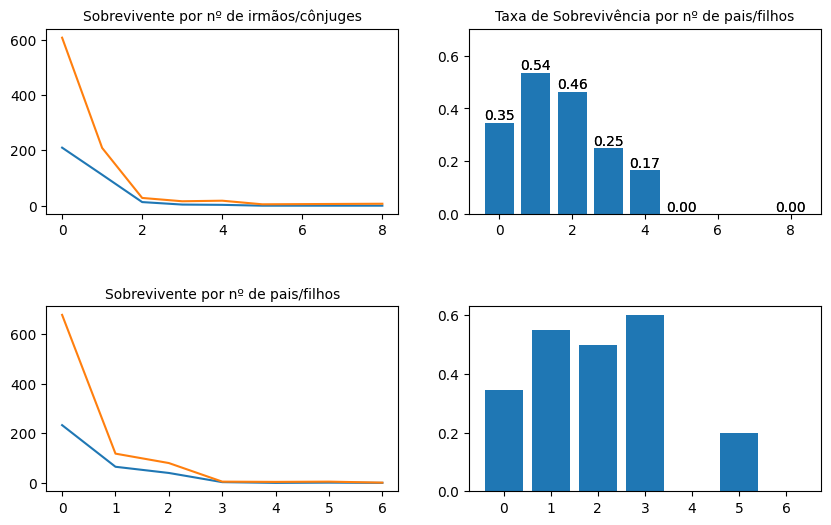

In [39]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,6))

ax[0,0].plot(SibSp_df.SibSp, SibSp_df.Sobreviventes)
ax[0,0].plot(SibSp_df.SibSp, SibSp_df.Total)
ax[0,0].set_title('Sobrevivente por nº de irmãos/cônjuges', fontsize=10)

labels1 = ax[0,1].bar(SibSp_df.SibSp, SibSp_df.taxa_sobrevivencia)
ax[0,1].bar_label(labels1, fmt='%.02f')
ax[0,1].set(ylim=(0, 0.6))
ax[0,1].set_title('Taxa de Sobrevivência por nº de irmãos/cônjuges', fontsize=10)

ax[1,0].plot(Parch_df.Parch, Parch_df.Sobreviventes)
ax[1,0].plot(Parch_df.Parch, Parch_df.Total)
ax[1,0].set_title('Sobrevivente por nº de pais/filhos', fontsize=10)

labels2 = ax[1,1].bar(Parch_df.Parch, Parch_df.taxa_sobrevivencia)
ax[0,1].bar_label(labels1, fmt='%.02f')
ax[0,1].set(ylim=(0, 0.7))
ax[0,1].set_title('Taxa de Sobrevivência por nº de pais/filhos', fontsize=10)

plt.subplots_adjust(hspace=0.5)

plt.show()

* Passageiros viajando sozinho tem uma menor taxa de sobrevivência
    - É interessante identificar quais dos passageiros está viajando sozinho para atribuir ao modelo

In [40]:
def sozinho(a, b):
    if (a == 0 and b == 0):
        return 1
    else:
        return 0

In [41]:
treino['Sozinho'] = treino.apply(lambda x: sozinho(x.SibSp, x.Parch), axis=1)

In [42]:
treino.groupby('Sozinho')[['SibSp', 'Parch']].max()

,SibSp,Parch
Sozinho,,
0,8,6
1,0,0


In [43]:
teste['Sozinho'] = teste.apply(lambda x: sozinho(x.SibSp, x.Parch), axis=1)

* Agora, criando uma coluna para passageiros com familiares a bordo

In [44]:
treino['Familiares'] = treino.SibSp + treino.Parch

In [45]:
teste['Familiares'] = teste.SibSp + teste.Parch

In [46]:
treino.groupby('Familiares')['Survived'].agg(['sum', 'count', 'mean']).reset_index()

,Familiares,sum,count,mean
0,0,163,537,0.303538
1,1,89,161,0.552795
2,2,59,102,0.578431
3,3,21,29,0.724138
4,4,3,15,0.200000
5,5,3,22,0.136364
6,6,4,12,0.333333
7,7,0,6,0.000000
8,10,0,7,0.000000


In [47]:
Familiares_df = treino.groupby('Familiares')['Survived'].agg(['sum', 'count', 'mean']).reset_index()
Familiares_df = treino.groupby('Familiares')['Survived'].agg(['sum', 'count', 'mean']).reset_index()
Familiares_df.columns = ['Familiares', 'Sobreviventes', 'Total', 'taxa_sobrevivencia']

In [48]:
Familiares_df

,Familiares,Sobreviventes,Total,taxa_sobrevivencia
0,0,163,537,0.303538
1,1,89,161,0.552795
2,2,59,102,0.578431
3,3,21,29,0.724138
4,4,3,15,0.200000
5,5,3,22,0.136364
6,6,4,12,0.333333
7,7,0,6,0.000000
8,10,0,7,0.000000


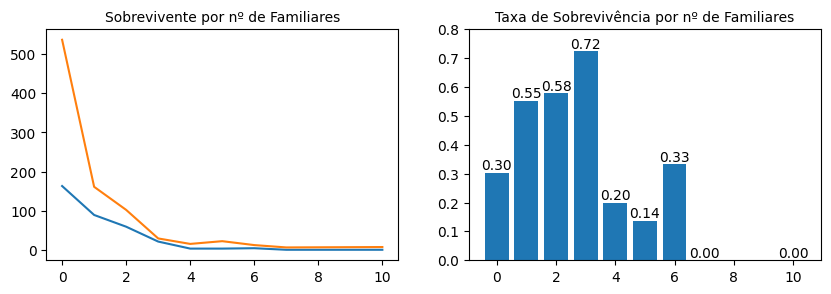

In [49]:
fig, ax = plt.subplots(ncols=2, figsize=(10,3))

ax[0].plot(Familiares_df.Familiares, Familiares_df.Sobreviventes)
ax[0].plot(Familiares_df.Familiares, Familiares_df.Total)
ax[0].set_title('Sobrevivente por nº de Familiares', fontsize=10)

labels1 = ax[1].bar(Familiares_df.Familiares, Familiares_df.taxa_sobrevivencia)
ax[1].bar_label(labels1, fmt='%.02f')
ax[1].set(ylim=(0, 0.8))
ax[1].set_title('Taxa de Sobrevivência por nº de Familiares', fontsize=10)

plt.show()

* O que podemos analisar deste gráfico?
    - Pessoas que viajam em família, entre 1 a 3 pessoas, tem uma maior taxa de sobrevivência

#### Usando esta nova base de dados no modelo

In [50]:
treino.head(3)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,MaleCheck,Embarked_C,Embarked_Q,Embarked_S,Sozinho,Familiares
0,1,0,3,-0.592240,1,0,-0.312011,1,0,0,1,0,1
1,2,1,1,0.638529,1,0,2.461242,0,1,0,0,0,1
2,3,1,3,-0.284548,0,0,-0.282777,0,0,0,1,1,0


In [51]:
teste.head(3)

,PassengerId,Pclass,Age,SibSp,Parch,Fare,MaleCheck,Embarked_C,Embarked_Q,Embarked_S,Sozinho,Familiares
0,892,3,0.331562,0,0,-0.280670,1,0,1,0,1,0
1,893,3,1.311954,1,0,-0.315800,0,0,0,1,0,1
2,894,2,2.488424,0,0,-0.201943,1,0,1,0,1,0


* Aplicando nos modelos

In [52]:
X = treino.drop(['PassengerId', 'Survived'], axis=1)
y = treino.Survived

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

* Árvore de Classificação

In [53]:
clf_ac = tree.DecisionTreeClassifier(random_state=42)
clf_ac = clf_ac.fit(X_train, y_train)

y_pred_ac = clf_ac.predict(X_val)

as_ac = accuracy_score(y_val, y_pred_ac)

as_ac

0.735593220338983

* KNN

In [54]:
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn = clf_knn.fit(X_train, y_train)

y_pred_knn = clf_knn.predict(X_val)

as_knn = accuracy_score(y_val, y_pred_knn)

as_knn

0.7864406779661017

* Regressão Logística

In [55]:
clf_rl = LogisticRegression(random_state=42, max_iter=1000)
clf_rl = clf_rl.fit(X_train, y_train)

y_pred_rl = clf_rl.predict(X_val)

as_rl = accuracy_score(y_val, y_pred_rl)

as_rl

0.8067796610169492

* Salvando no DataFrame

In [56]:
as_df['Compania'] = [as_ac, as_knn, as_rl]

In [57]:
as_df

,modelos,inicial,escala,Compania
0,arvore,0.749153,0.749153,0.735593
1,knn,0.715254,0.800000,0.786441
2,reg. log.,0.816949,0.816949,0.806780


* Conclusões: Ao adicionarmos as duas novas colunas que remete-se ao passageiro estar sozinho ou acompanhado, piorou todos os nossos modelos. 
    - Importante: Não significa que a adição das colunas seja ruim, talvez seja necessário reavaliar quais features devem ser passadar para o modelo.

#### Selecionando as melhores variavéis (features) do modelo

* Precisamos analisar qual a **correlação entre as variáveis** e verificar se existe variáveis "repetidas"

In [58]:
# Visualizando a base
treino.head(3)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,MaleCheck,Embarked_C,Embarked_Q,Embarked_S,Sozinho,Familiares
0,1,0,3,-0.592240,1,0,-0.312011,1,0,0,1,0,1
1,2,1,1,0.638529,1,0,2.461242,0,1,0,0,0,1
2,3,1,3,-0.284548,0,0,-0.282777,0,0,0,1,1,0


In [59]:
treino.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,MaleCheck,Embarked_C,Embarked_Q,Embarked_S,Sozinho,Familiares
PassengerId,1.000000,-0.005007,-0.035144,0.033207,-0.057527,-0.001652,0.012658,0.042939,-0.001205,-0.033606,0.022204,0.057462,-0.040143
Survived,-0.005007,1.000000,-0.338481,-0.069809,-0.035322,0.081629,0.257307,-0.543351,0.168240,0.003650,-0.149683,-0.203367,0.016639
Pclass,-0.035144,-0.338481,1.000000,-0.331339,0.083081,0.018443,-0.549500,0.131900,-0.243292,0.221009,0.074053,0.135207,0.065997
Age,0.033207,-0.069809,-0.331339,1.000000,-0.232625,-0.179191,0.091566,0.084153,0.032024,-0.013855,-0.019336,0.179775,-0.248512
SibSp,-0.057527,-0.035322,0.083081,-0.232625,1.000000,0.414838,0.159651,-0.114631,-0.059528,-0.026354,0.068734,-0.584471,0.890712
Parch,-0.001652,0.081629,0.018443,-0.179191,0.414838,1.000000,0.216225,-0.245489,-0.011069,-0.081228,0.060814,-0.583398,0.783111
Fare,0.012658,0.257307,-0.549500,0.091566,0.159651,0.216225,1.000000,-0.182333,0.269335,-0.117216,-0.162184,-0.271832,0.217138
MaleCheck,0.042939,-0.543351,0.131900,0.084153,-0.114631,-0.245489,-0.182333,1.000000,-0.082853,-0.074115,0.119224,0.303646,-0.200988
Embarked_C,-0.001205,0.168240,-0.243292,0.032024,-0.059528,-0.011069,0.269335,-0.082853,1.000000,-0.148258,-0.782742,-0.095298,-0.046215
Embarked_Q,-0.033606,0.003650,0.221009,-0.013855,-0.026354,-0.081228,-0.117216,-0.074115,-0.148258,1.000000,-0.499421,0.086464,-0.058592


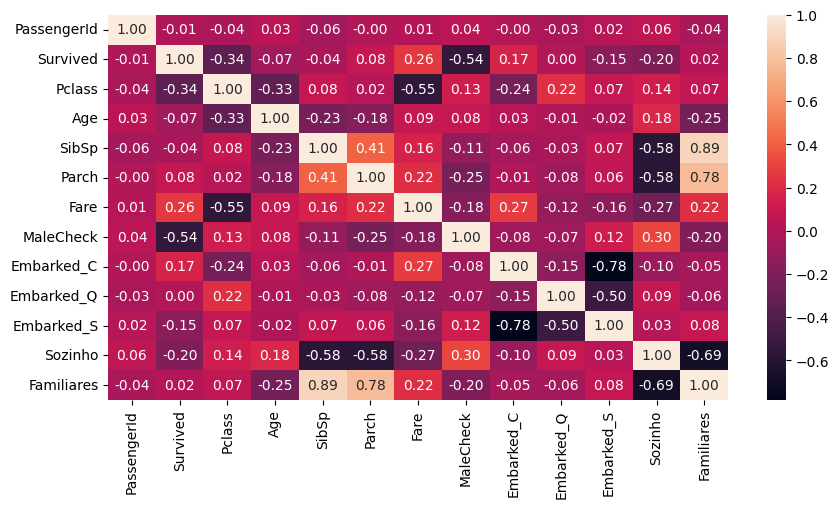

In [60]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,5))

sns.heatmap(treino.corr(), annot=True, fmt=".2f")

plt.show()

* Algumas análises prévias podem surgiur com as correlações:
    - Colunas como **Pclass** e **Fare** tem alta correlação, já que o valor da passagem da primeira classe é alto;

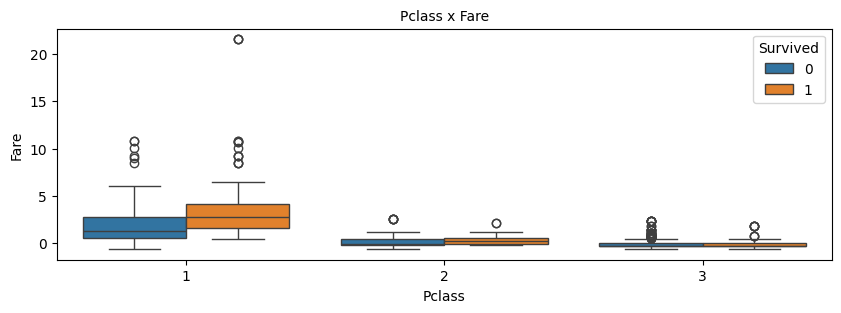

In [61]:
fig, ax = plt.subplots(figsize=(10,3))

sns.boxplot(data=treino, x='Pclass', y='Fare', hue='Survived')
ax.set_title('Pclass x Fare', fontsize=10)

plt.show()

* Nota-se que, a probabilidade de passageiros na 2ª e 3ª classe tem uma menor probabilidade de sobreviver.

In [62]:
# Taxa de sobrevivência para classe
treino.groupby('Pclass')['Survived'].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [63]:
treino.groupby(['Pclass', 'Survived'])['Fare'].agg(['min', 'mean', 'max'])

min      mean        max
Pclass Survived                               
1      0        -0.626005  2.175430  10.764405
       1         0.496977  3.514735  21.562738
2      0        -0.626005  0.214734   2.557247
       1        -0.171255  0.329217   2.189115
3      0        -0.626005 -0.033991   2.386174
       1        -0.626005 -0.032885   1.820802

* Essas duas colunas, apesar de ter uma forte correlação, não devem ser excluidas, pois uma não substitui a outra.

* Agora podemos analisar a coluna de Embarque:
    - Existe correlação entre o preço da passagem e o porto de embarque;
    - A ordem em que o Titanic parou nos portos foi: S -> C -> Q
    - Aqui, o valor da passagem em Q tende a ser mais barato

In [64]:
treino2 = pd.read_csv('DataBase/train.csv')
teste2 = pd.read_csv('DataBase/test.csv')

treino2.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


* Como existem valores vazios na coluna **Embarked**, vamos atribuir a eles o valor que mais aparece (moda).

In [65]:
treino2['Embarked'] = treino2['Embarked'].fillna('S')

* Vamos ordenar os portos em S -> C -> Q com o **OrdinalEncoder**

In [66]:
from sklearn.preprocessing import OrdinalEncoder

In [67]:
categorias = ['S', 'C', 'Q']

enc = OrdinalEncoder(categories=[categorias], dtype='int32')

In [68]:
enc = enc.fit(treino2[['Embarked']])

In [69]:
# Voltando para a base de treino original
treino['Embarked'] = enc.transform(treino2[['Embarked']])

In [70]:
enc = enc.fit(teste2[['Embarked']])

In [71]:
# Voltando para a base de teste original
teste['Embarked'] = enc.transform(teste2[['Embarked']])

In [72]:
treino.head(3)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,MaleCheck,Embarked_C,Embarked_Q,Embarked_S,Sozinho,Familiares,Embarked
0,1,0,3,-0.592240,1,0,-0.312011,1,0,0,1,0,1,0
1,2,1,1,0.638529,1,0,2.461242,0,1,0,0,0,1,1
2,3,1,3,-0.284548,0,0,-0.282777,0,0,0,1,1,0,0


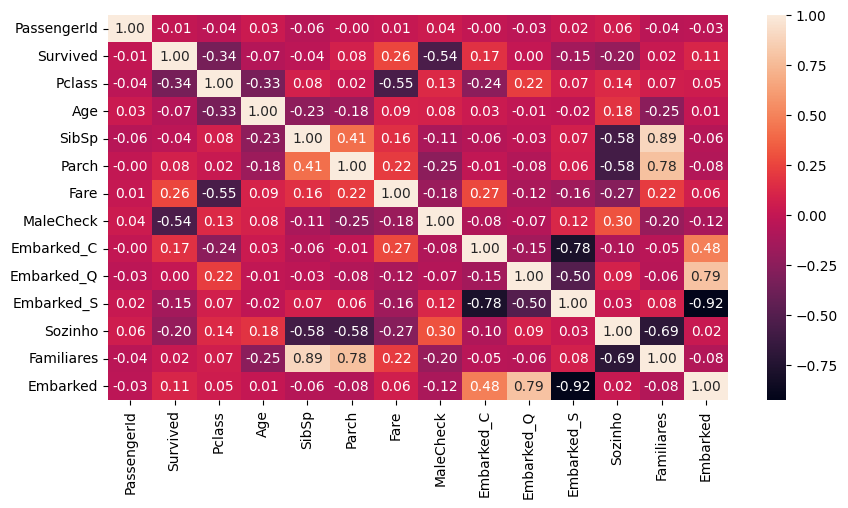

In [73]:
fig, ax = plt.subplots(figsize=(10,5))

sns.heatmap(treino.corr(), annot=True, fmt=".2f")

plt.show()

* Agora podemos observar as colunas relacionadas aos parentes:
    - Utilizando a regressão logística e árvore de classificação para verificar a importância dos dados

In [74]:
X = treino.drop(['PassengerId', 'Survived'], axis=1)
y = treino.Survived

In [75]:
clf_rl = LogisticRegression(random_state=42, max_iter=1000).fit(X, y)

In [76]:
clf_rl.coef_[0]

array([-1.02269243, -0.49324275, -0.26338737,  0.01474001,  0.04133637,
       -2.54190773,  0.07918487,  0.02950482, -0.10585136, -0.71612345,
       -0.24864735,  0.13819452])

In [77]:
clf_ac = tree.DecisionTreeClassifier(random_state=42).fit(X, y)

In [78]:
clf_ac.feature_importances_

array([0.10502953, 0.24177299, 0.03801774, 0.01309536, 0.22307212,
       0.30933519, 0.0018837 , 0.00092223, 0.00472357, 0.00548339,
       0.04946366, 0.00720052])

In [79]:
imp = pd.DataFrame({
    'colunas': X.columns,
    'reg. log.': clf_rl.coef_[0],
    'arvore': clf_ac.feature_importances_
})

imp

,colunas,reg. log.,arvore
0,Pclass,-1.022692,0.105030
1,Age,-0.493243,0.241773
2,SibSp,-0.263387,0.038018
3,Parch,0.014740,0.013095
4,Fare,0.041336,0.223072
5,MaleCheck,-2.541908,0.309335
6,Embarked_C,0.079185,0.001884
7,Embarked_Q,0.029505,0.000922
8,Embarked_S,-0.105851,0.004724
9,Sozinho,-0.716123,0.005483


1. A coluna *Sozinho* tem um valor negativo alto para o modelo de Regressão Logística
2. As colunas *SibSp* e *Parch* tem valores baixos e *Familiares* tem um valor um pouco menor que *SibSp*, mas devemos lembrar que a coluna *Familiares* foi uma junção de *SibSp* e *Parch*
3. Já para a Árvore de Decisão, a coluna *Familiares* é mais importante que a coluna *Sozinho*, *SibSp* e *Parch*

* Por fim, uma possível análise seria excluir as colunas *SibSp* e *Parch*

In [80]:
treino = treino.drop(['SibSp', 'Parch'], axis=1)
teste = teste.drop(['SibSp', 'Parch'], axis=1)

In [81]:
treino.head(3)

,PassengerId,Survived,Pclass,Age,Fare,MaleCheck,Embarked_C,Embarked_Q,Embarked_S,Sozinho,Familiares,Embarked
0,1,0,3,-0.592240,-0.312011,1,0,0,1,0,1,0
1,2,1,1,0.638529,2.461242,0,1,0,0,0,1,1
2,3,1,3,-0.284548,-0.282777,0,0,0,1,1,0,0


* Avaliando os modelos com este novo dataset

In [82]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

* Árvore de Decisão

In [83]:
clf_ac = tree.DecisionTreeClassifier(random_state=42)
clf_ac = clf_ac.fit(X_train, y_train)

y_pred_ac = clf_ac.predict(X_val)

as_ac = accuracy_score(y_val, y_pred_ac)

as_ac

0.7559322033898305

In [84]:
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn = clf_knn.fit(X_train, y_train)

y_pred_knn = clf_knn.predict(X_val)

as_knn = accuracy_score(y_val, y_pred_knn)

as_knn

0.7762711864406779

In [85]:
clf_rl = LogisticRegression(random_state=42, max_iter=1000)
clf_rl = clf_rl.fit(X_train, y_train)

y_pred_rl = clf_rl.predict(X_val)

as_rl = accuracy_score(y_val, y_pred_rl)

as_rl

0.8067796610169492

In [86]:
as_df['ajustes'] = [as_ac, as_knn, as_rl]

In [87]:
as_df

,modelos,inicial,escala,Compania,ajustes
0,arvore,0.749153,0.749153,0.735593,0.755932
1,knn,0.715254,0.800000,0.786441,0.776271
2,reg. log.,0.816949,0.816949,0.806780,0.806780


In [88]:
treino.head(3)

,PassengerId,Survived,Pclass,Age,Fare,MaleCheck,Embarked_C,Embarked_Q,Embarked_S,Sozinho,Familiares,Embarked
0,1,0,3,-0.592240,-0.312011,1,0,0,1,0,1,0
1,2,1,1,0.638529,2.461242,0,1,0,0,0,1,1
2,3,1,3,-0.284548,-0.282777,0,0,0,1,1,0,0
